# Pre-processing workflow
## EMG
- output: .txt file containing 12 channels as well as the names of channels corresponding to these 12 columns in the .txt file
## EEG
- NE recording device measured .easy file
- EEGLAB preprocessing including FILTER PREP ICA (whether or not epoched is not yet decided)
- output: .set file 

## EMG channels locations
for convenience, polar coordinates are firstly and visually defined


In [125]:
# Define EMGChannel class
# the unit of phi is degree

from itertools import count

class EMGChannel:
    '''with polar coordinates as inputs'''
    
    _ids = count(0)
    
    def __init__(self, rho, phi,name="None"):
        self.id = next(self._ids)
        self.rho = rho
        self.phi = phi
        self.name = name
        self.x = rho * np.cos(phi/180*np.pi)
        self.y = rho * np.sin(phi/180*np.pi)
        
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=10, ha="center")
        return ax        
    
    def cartesianC(self):
        return(self.x, self.y)
    
    def polarC(self):
        return(self.rho,self.phi)
    

In [126]:
#polar object definition - with transformation method

EMGs=[EMGChannel(3,120,'emg1'),EMGChannel(3,-90,'emg2'),EMGChannel(3, 20,'emg3'),EMGChannel(2,-150,'emg4'),
      EMGChannel(2,-70,'emg5'),EMGChannel(2, 45,'emg6'),EMGChannel(2,100,'emg7'),EMGChannel(8, -10,'emg8'),
      EMGChannel(1,170,'emg9'),EMGChannel(1,85,'emg10'),EMGChannel(1, 0,'emg11'),EMGChannel(1,-100,'emg12')]

import numpy as np
import mne 
import pandas as pd

############### Parameters ###################
#Data
num_emgs = 12
sfreq = 100
num_trials = 10
trials_interval = 12
#############################################

######################## Read EMG (test 10 trials - 120 secs)
ch_types = ['emg']*num_emgs
ch_names = []
for i in range(num_emgs):
    ch_names.append('emg'+str(i+1))
emg_data = pd.read_csv('D:/Scripts/EEG-EMG/EMG_12_channels.txt', header = None, 
                       sep = '\t',engine = 'python')
emg_data = emg_data.T
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)

########### read eeg set data, its montage and resample EEG to 100Hz ####################
eeg_fname = 'D:/Data/CMC11Nov/czf11Nov.set'
epochs_eeg = mne.io.read_epochs_eeglab(eeg_fname)
epochs_eeg.set_montage('standard_1020')
epochs_eeg_resampled = epochs_eeg.copy().resample(sfreq, npad='auto')

### EMG Rvent engineering ###
# annotation editing, code of begining of each trial '2' # - '2' is a string
annotations_df = pd.DataFrame()
onsets = np.array([trials_interval*i for i in range(num_trials)])
durations = np.repeat(0, num_trials) # the begining of each trial does not represent specified event block
descriptions = ['2']*num_trials
annot_emg = mne.Annotations(onsets,durations,descriptions)
raw_emg.set_annotations(annot_emg)
events,events_code_dict = mne.events_from_annotations(raw_emg)

epochs_emg = mne.Epochs(raw_emg,events,events_code_dict['2'],tmin = 0, tmax = 11.989,baseline=(0, 2),preload=True) 

######################################## Drop Epochs occasionnaly for test #############################################
mask = [True]*45 + [False]*10
epochs_eeg_resampled.drop(mask)
########################################################################

epochs_eeg_resampled.add_channels([epochs_emg])

Creating RawArray with float64 data, n_channels=12, n_times=12000
    Range : 0 ... 11999 =      0.000 ...   119.990 secs
Ready.
Extracting parameters from D:/Data/CMC11Nov/czf11Nov.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-126-d307d550c91e>:32: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs_eeg = mne.io.read_epochs_eeglab(eeg_fname)


DigMontage is a superset of info. 62 in DigMontage will be ignored. The ignored channels are: {'PO2', 'P10', 'C1', 'CP3', 'A2', 'Fpz', 'FT8', 'POz', 'PO7', 'PO6', 'FT9', 'PO5', 'PO1', 'AF10', 'P2', 'P6', 'TP8', 'TP9', 'O9', 'C5', 'F2', 'FCz', 'F6', 'AF8', 'T3', 'TP10', 'F5', 'Iz', 'CPz', 'C2', 'CP4', 'FT7', 'AF9', 'AF5', 'AFz', 'PO10', 'M2', 'FC3', 'P9', 'T5', 'FC4', 'AF1', 'FT10', 'A1', 'P1', 'M1', 'O10', 'AF7', 'C6', 'PO9', 'TP7', 'P5', 'T9', 'T4', 'F1', 'T6', 'AF6', 'T10', 'F9', 'F10', 'AF2', 'PO8'}
Used Annotations descriptions: ['2']
10 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 10 events and 1200 original time points ...
0 bad epochs dropped
Dropped 45 epochs


<EpochsEEGLAB  |   10 events (all good), 0 - 11.99 sec, baseline off, ~4.1 MB, data loaded,
 '1': 1
 '1/1': 9>

Dropped 0 epochs
Channels marked as bad: []


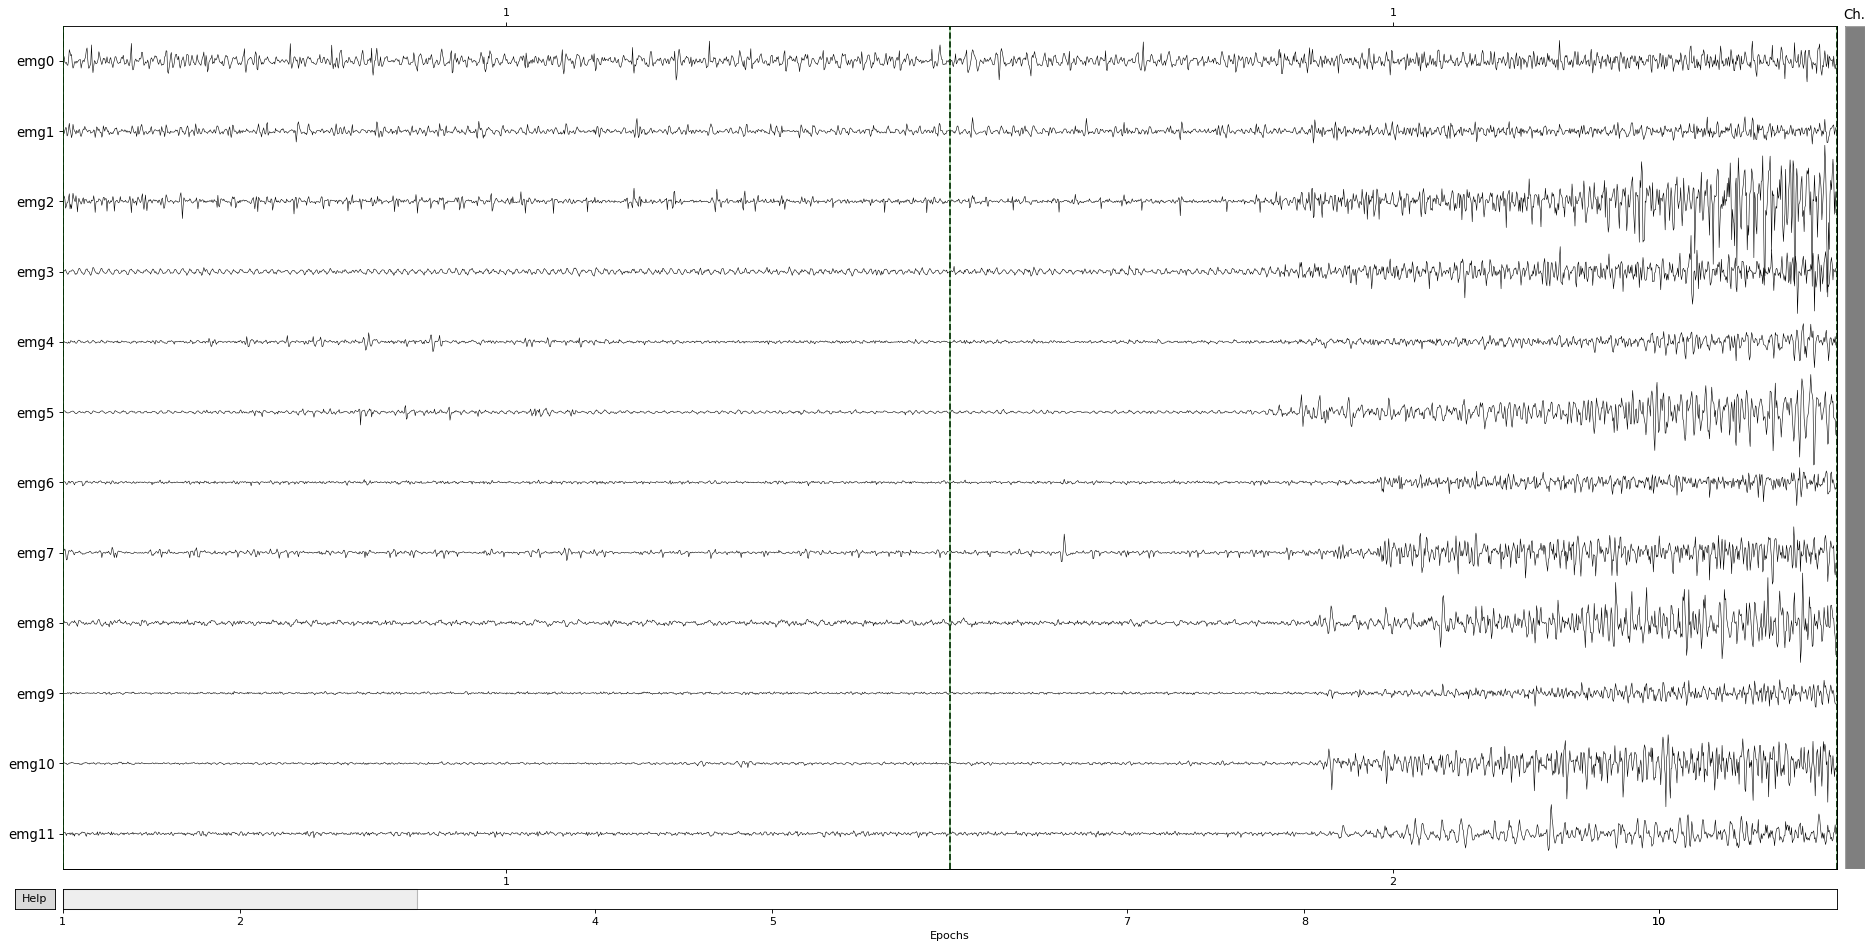

Dropped 0 epochs
Channels marked as bad: []


In [42]:
%matplotlib qt
# Validation of EMG data
epochs_emg.plot(picks='all',scalings = 1e-1,n_epochs=2)

In [116]:
# Connectivity for 2-8Hz band and calculate MST
#Important - link to the channel name
from mne.connectivity import spectral_connectivity
import networkx as nx

epochs_hybrid = epochs_eeg_resampled.copy()
epochs_hybrid.load_data()
fmin = 2
fmax = 8
tmin = 0
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs_hybrid, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)


cntvt_graph = nx.Graph(con[:, :, 0])
mst_cntvt = nx.maximum_spanning_tree(cntvt_graph)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 946 connections
    using t=0.000s..11.990s for estimation (1200 points)
    frequencies: 2.0Hz..8.0Hz (73 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


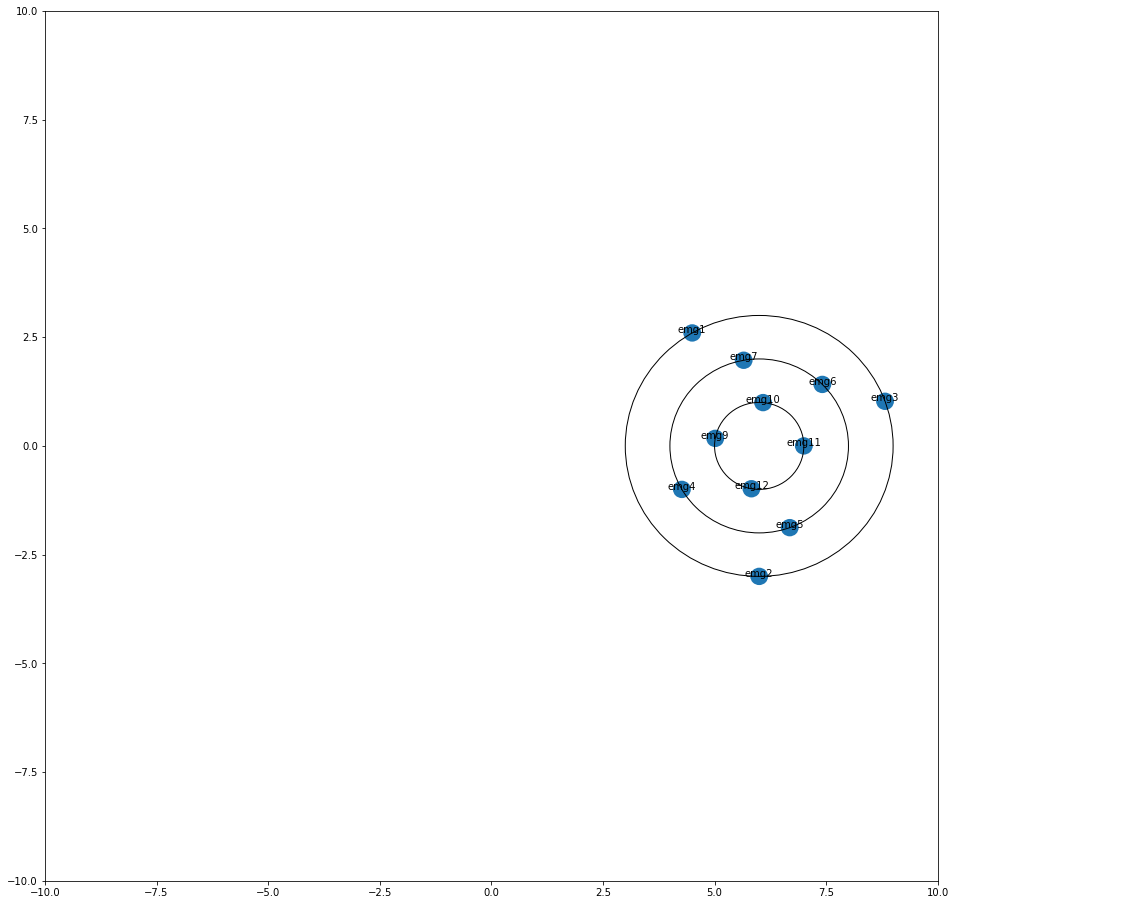

In [129]:
# 2D Visualization
# head's center is at (-6,0) while that of arm is at (6,0)

%matplotlib inline
import matplotlib.pyplot as plt

# EMG bv
def plotTopoEMG(EMGs,ax,center=[6,0]):
    for i in range(3):
        circle = plt.Circle((center[0],center[1]), i+1,fill = False)
        ax.add_artist(circle)
    for EMG in EMGs:
        ax = EMG.plot(ax,center)
    return ax


plt.figure(figsize=(16, 16), facecolor='w', edgecolor='k')
ax = plt.gca()
ax = plotTopo(EMGs,ax)


plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()


In [124]:
#Visualize EEG   

-1.4999999999999993
1.7418335526369428
1.8369701987210297e-16
-2.6819899908016733
2.8190778623577253
2.738835752182883
-1.7320508075688774
1.4297528592583293
0.6840402866513376
-1.5477813631157782
1.4142135623730951
1.7018070490682369
-0.3472963553338606
-1.0127312822195176
7.878462024097664
4.352168887114958
-0.984807753012208
0.3466494554970303
0.08715574274765836
-0.1760756199485871
1.0
0.0
-0.1736481776669303
0.5063656411097588
